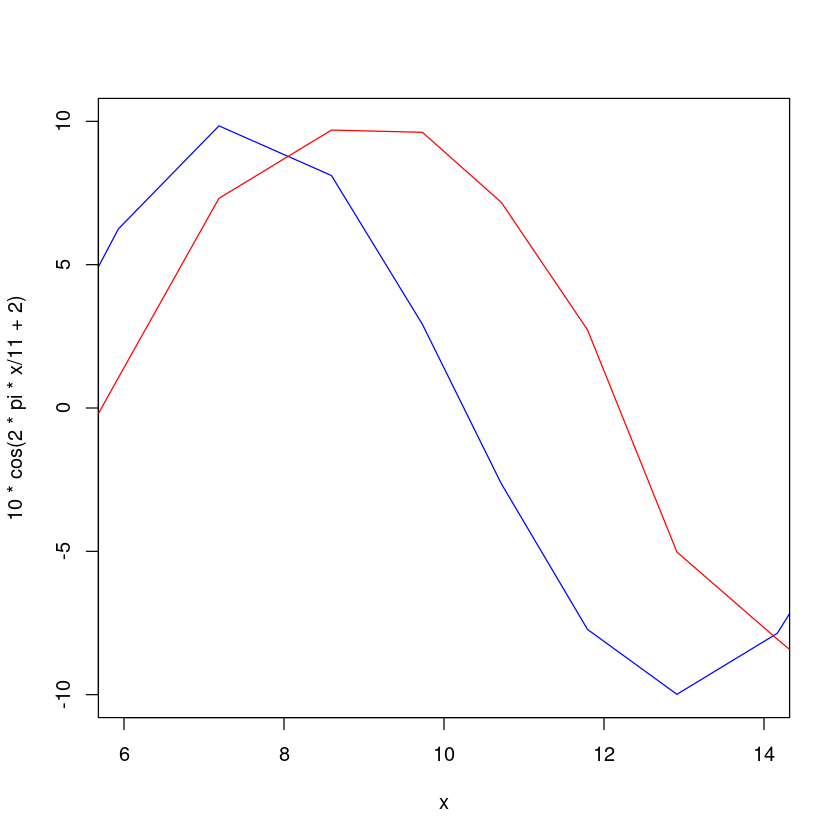

In [272]:
xis <- res$sample.param.timedep$xi
x <- cumsum(xis[nrow(xis),])
plot(x, 10*cos(2*pi * x / 11 + 2), col="blue", type="l", xlim=range(10))
lines(x, df1[[2]], col="red")


In [196]:
xi_samples <- res$sample.param.timedep$xi
xi_samples

1.000000,2.0000000,3.000000,4.0000000,5.0000000,6.0000000,7.000000,8.0000000,9.000000,10.0000000,⋯,491.0000000,492.0000000,493.000000,494.0000000,495.0000,496.0000000,497.0000000,498.0000000,499.0000,500.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.000000,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000,1.000000


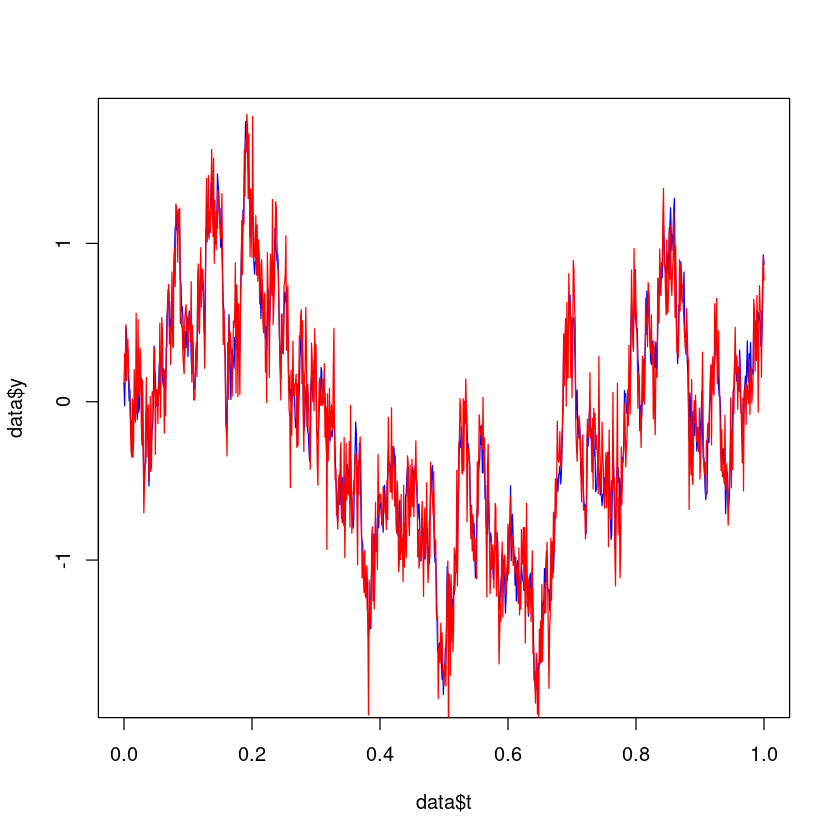

In [89]:
plot(data$t, data$y, type="l", col="blue")
lines(data$t, data$yobs, col="red")

# Example

In [322]:
# parameters for the model
y_mean <- 0
y_sd <- 1
y_gamma <- 10
obs_sd <- 0.2 # how spread are the values from the model values

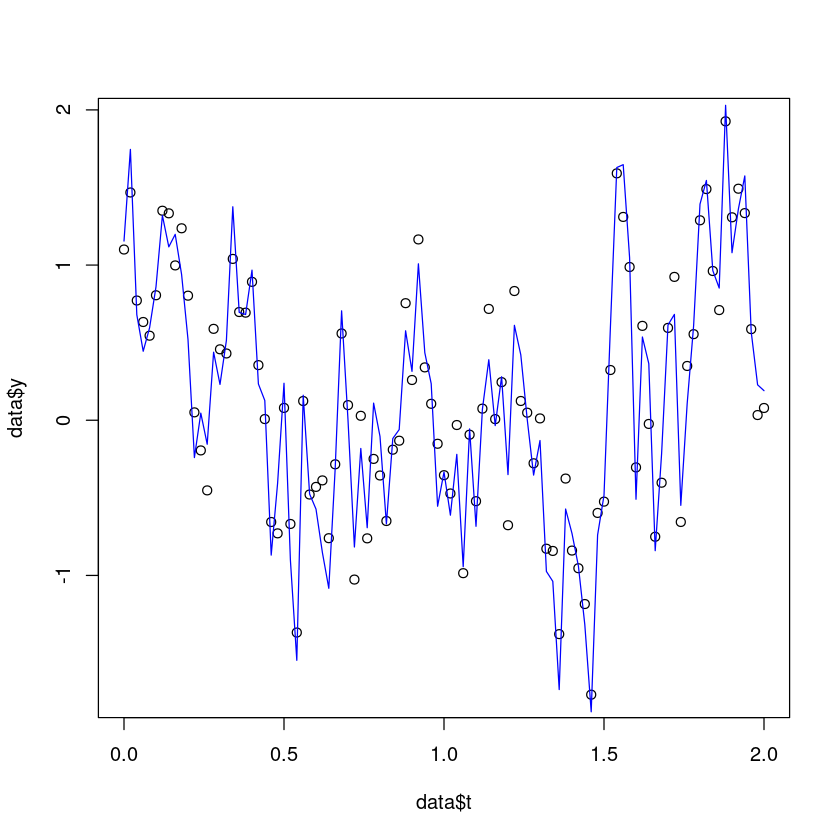

In [323]:
# generate synthetic data that follow a Ornstein-Uhlenbeck process
# it is used as the true hidden signal
data <- randOU(mean=y_mean, sd=y_sd, 
               gamma=y_gamma, t=seq(0,2,length.out=101))
# add noise to get simulated observations
data$yobs <- data$y + rnorm(nrow(data), mean=0, sd=obs_sd)

# plot the difference between model's data and observations' data
plot(data$t, data$y)
lines(data$t, data$yobs, col="blue")

# Alternative

In [49]:
col_names <- c("Year_1", "Cycle_1", "blank1", "Year_2", "Cycle_2", "blank2", "Year_3", "Cycle_3")
df <- read_excel("./data/syntheticData.xlsx", skip=4, col_names=col_names)
df1 <- df[,c(1,2)]
df2 <- df[,c(4,5)]
df3 <- df[,c(7,8)]

# specify the table to use
data = df1
t_name <- names(data)[1]
y_name <- names(data)[2]

# specify simulation parameters
n.iter <- 10000 
# n.iter <- 750
n.interval <- 25
n.adapt <- floor(0.4 * n.iter)

## likelihood
loglikeli <- function(param, data) {

  xi <- param$xi[, 2]
    if ( any(xi <= 0) ) return(-Inf)

  t  <- cumsum(xi)                 # corrected time axis
  omega  <- 2 * pi / 11            # fixed frequency
  y_hat  <- param$A * cos(omega * t + param$phi)

  sum(dnorm(data[[2]], mean = y_hat,
            sd   = param$sigma_y,
            log  = TRUE))
}

### DF1

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          3

  number of time-dependent parameters:    1

  number of estimated process parameters: 2



* proposal distribution of constant parameters:
correlation matrix:
        A phi sigma_y
A       1   0       0
phi     0   1       0
sigma_y 0   0       1
standard deviations:
      A     phi sigma_y 
    0.5     1.0     1.0 
log:
      A     phi sigma_y 
  FALSE   FALSE    TRUE 
scaling factor:
 0.05 
* proposal distribution of process parameters of time-dependent parameter xi :
correlation matrix:
        xi_mean xi_sd
xi_mean       1     0
xi_sd         0     1
standard deviations:
xi_mean   xi_sd 
      1       1 
logarithmic Ornstein-Uhlenbeck process
scaling factor:
 0.05 
iter = 0: A=5, phi=0, sigma_y=1, xi_mean=1, xi_sd=0.3
  logpost=-21291.11, logprior=0, logpdfou=148.0639, loglikeli=-21439.18
iter = 1: A=5.004, phi=0.02584, sigma_y=1.022, xi_mean=1, xi_sd=0.3
  logpost=-5401.591, logprior=0, logpdfou=97.05886, loglikeli=-5498.65
iter = 2: A=5.017, phi=0.04633, sigma_y=1.077, xi_mean=1.034, xi_sd=0.2917
  logpost=-4392.067, logprior=0, logpdfou=132.4703, loglikeli=-4524.537
i

10000 iterations completed

  acceptance frequency of constant parameters:             0.131

  acceptance frequencies of time-dependent parameters:     0.00229

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.16

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



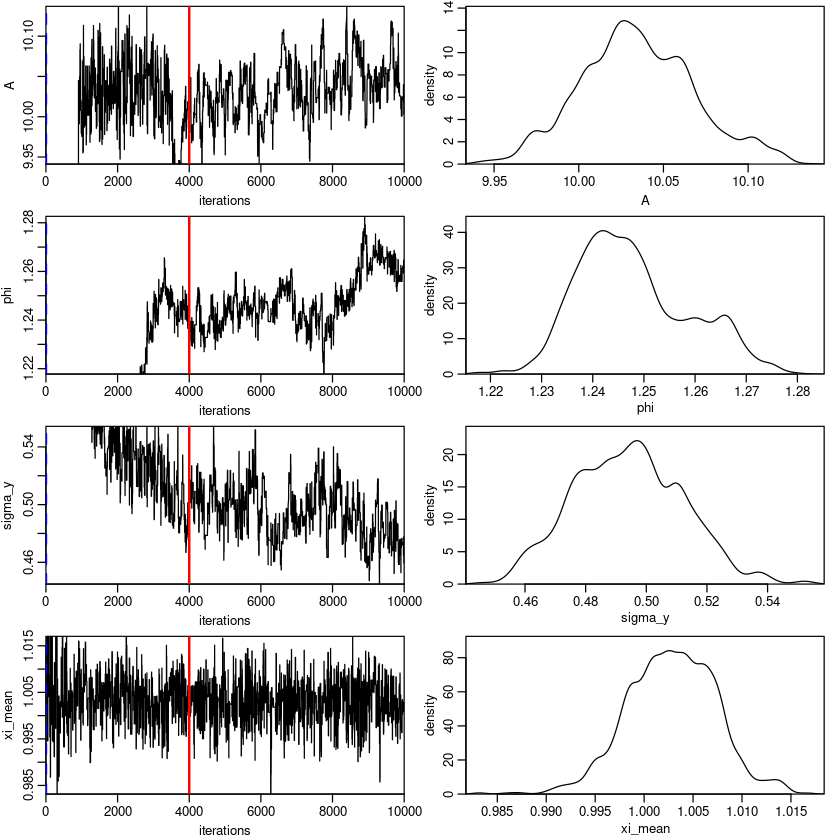

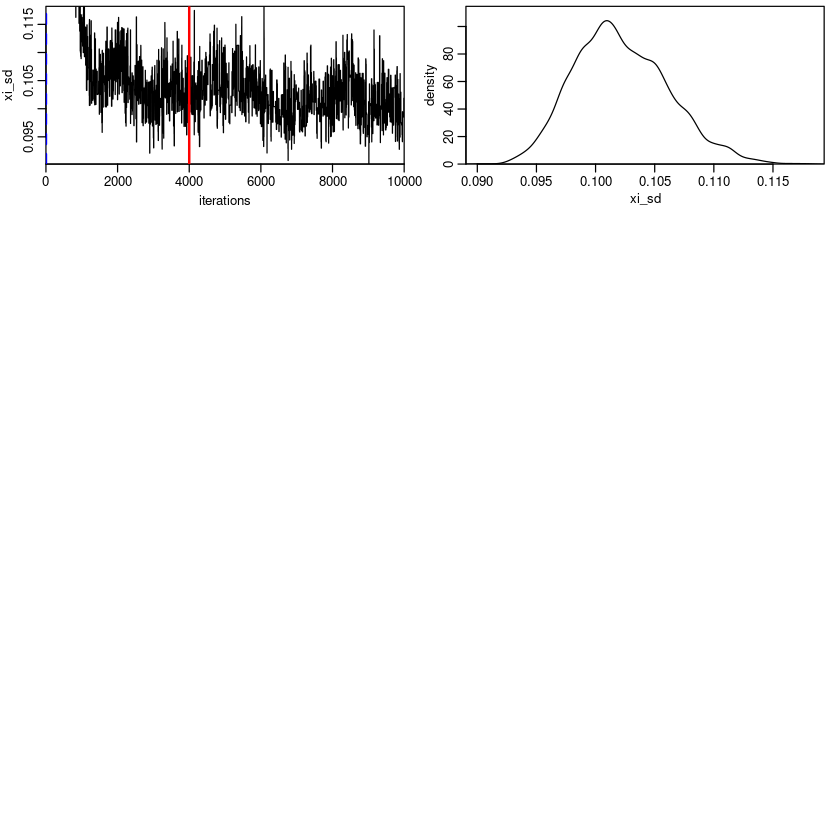

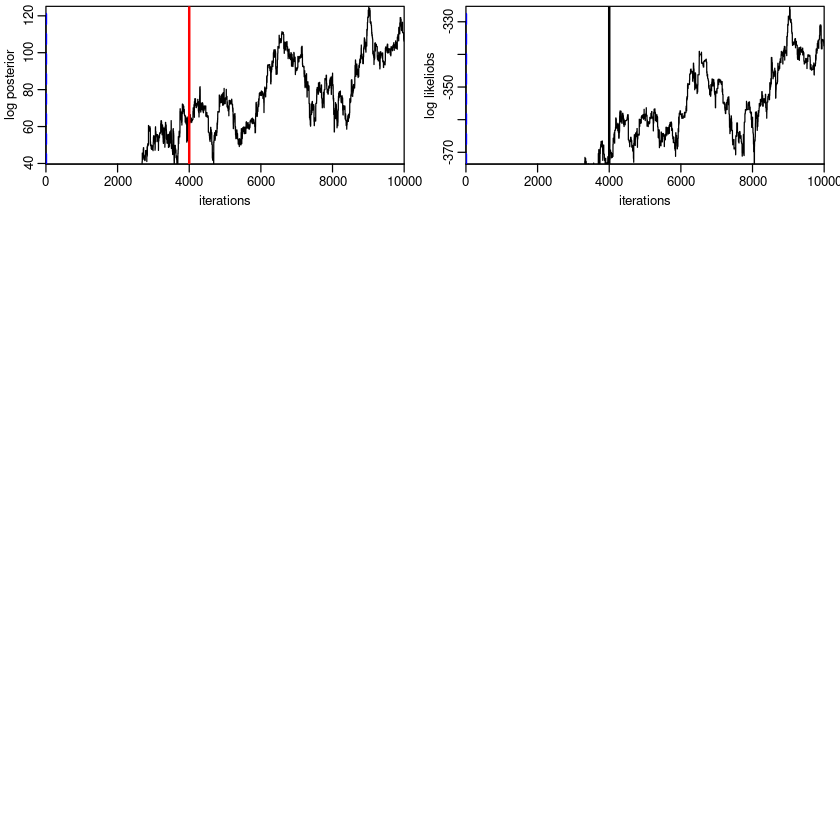

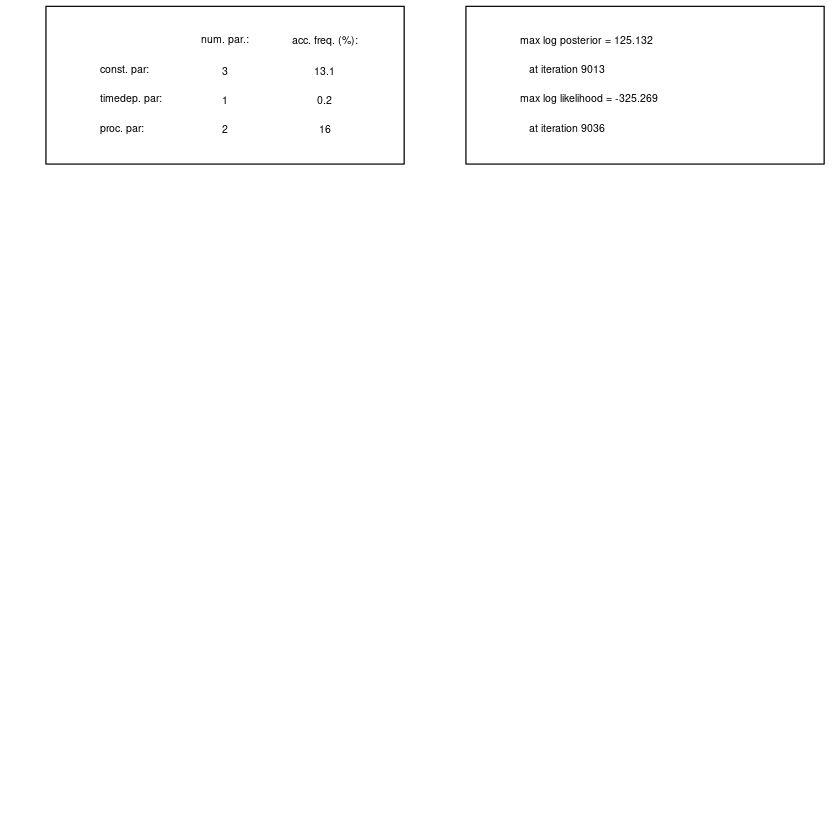

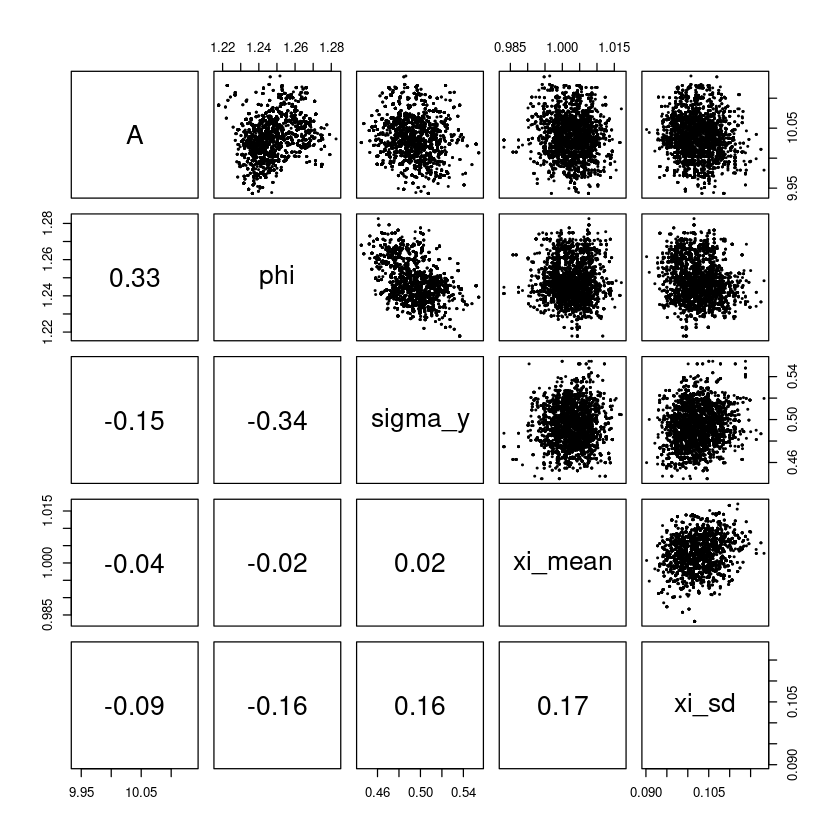

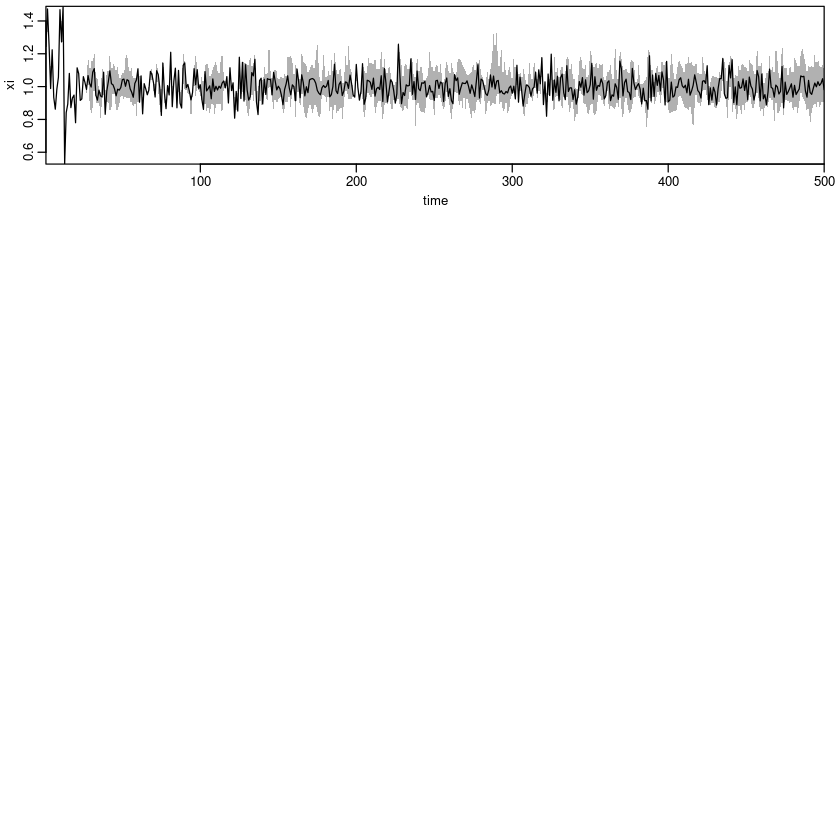

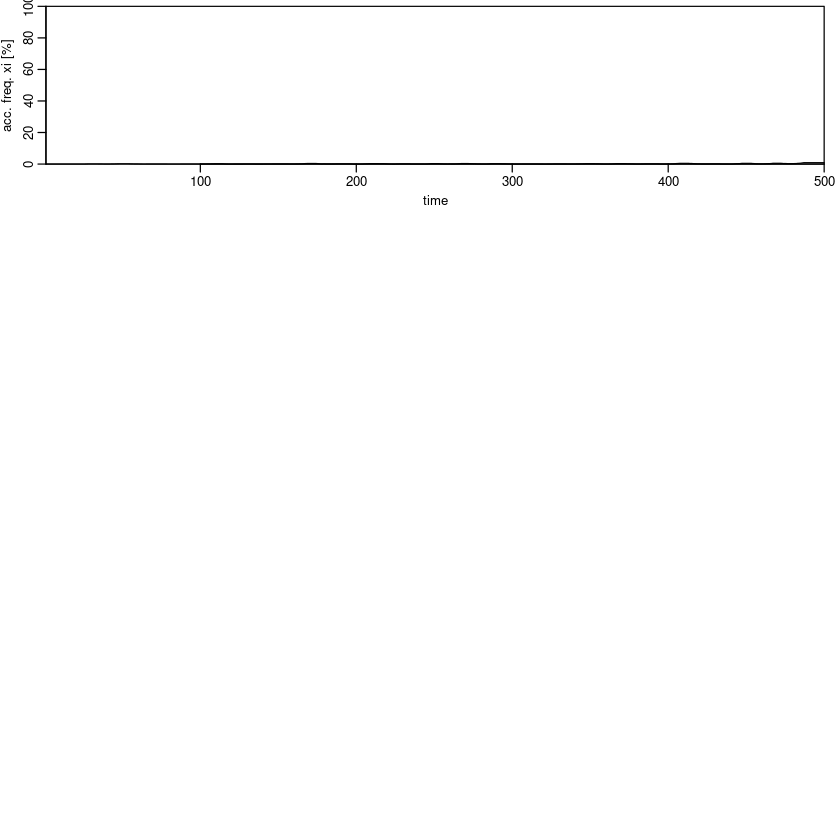

In [50]:
## 1. build proper two‑column matrix
xi_init <- cbind(
  time  = data[[t_name]],   # grid
  value = rep(1, nrow(data))# initial interval length
)

## 2. initial parameter list
param_init <- list(
  xi      = xi_init,
  A       = 5,
  phi     = 0,
  sigma_y = 1
)

## 3. call the sampler
res <- infer.timedeppar(
    loglikeli     = loglikeli,
    param.ini     = param_init,
    param.log     = c(A = FALSE, phi = FALSE,
                      sigma_y = TRUE,  # keep > 0
                      xi = TRUE),      # log‑normal OU for increments
  param.ou.ini  = c(xi_mean = 1, xi_sd = 0.3),
    param.ou.fixed = c(xi_gamma=5),
  n.iter        = n.iter,
  control       = list(n.interval=n.interval, n.adapt=n.adapt),
  data          = data,
  verbose       = 1
)

plot(res);

## DF2

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          3

  number of time-dependent parameters:    1

  number of estimated process parameters: 2

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

50000 iterations completed

  acceptance frequency of constant parameters:             0.235

  acceptance frequencies of time-dependent parameters:     0.000591

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.181

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



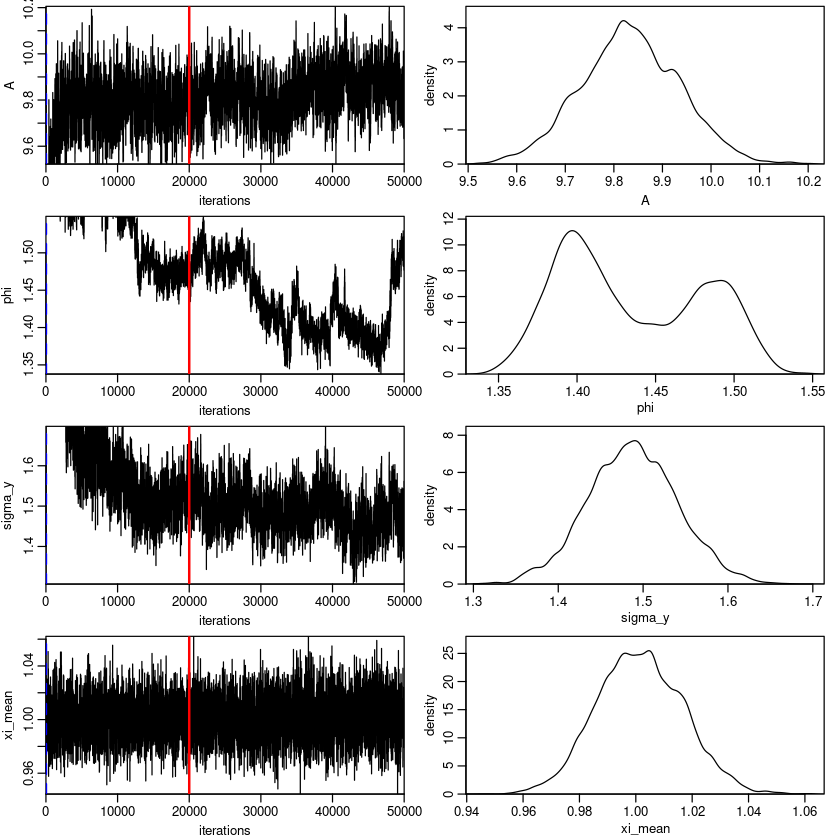

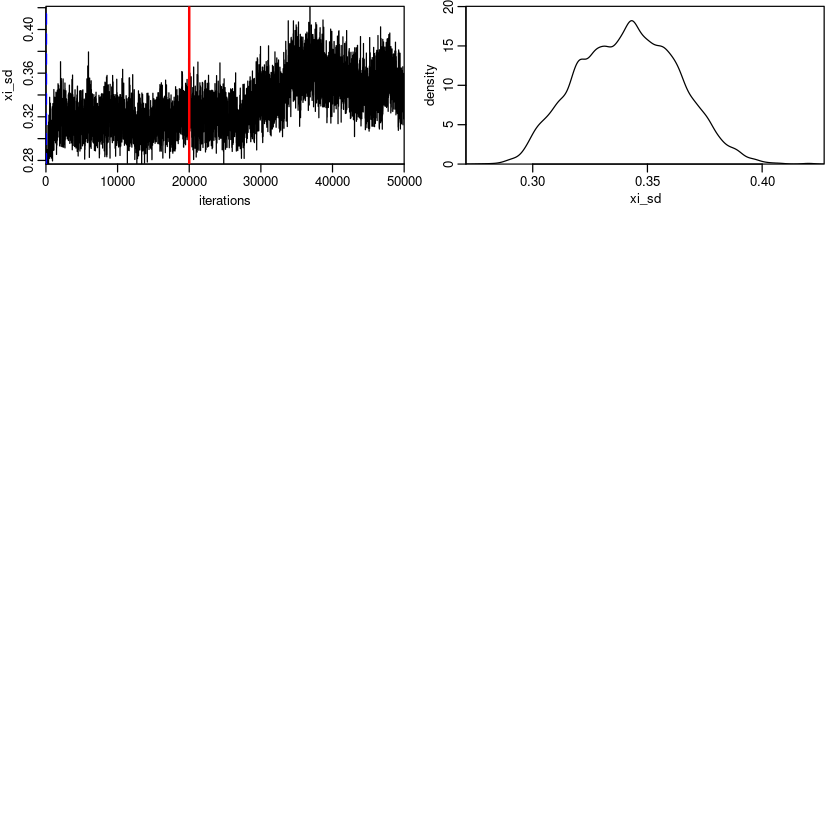

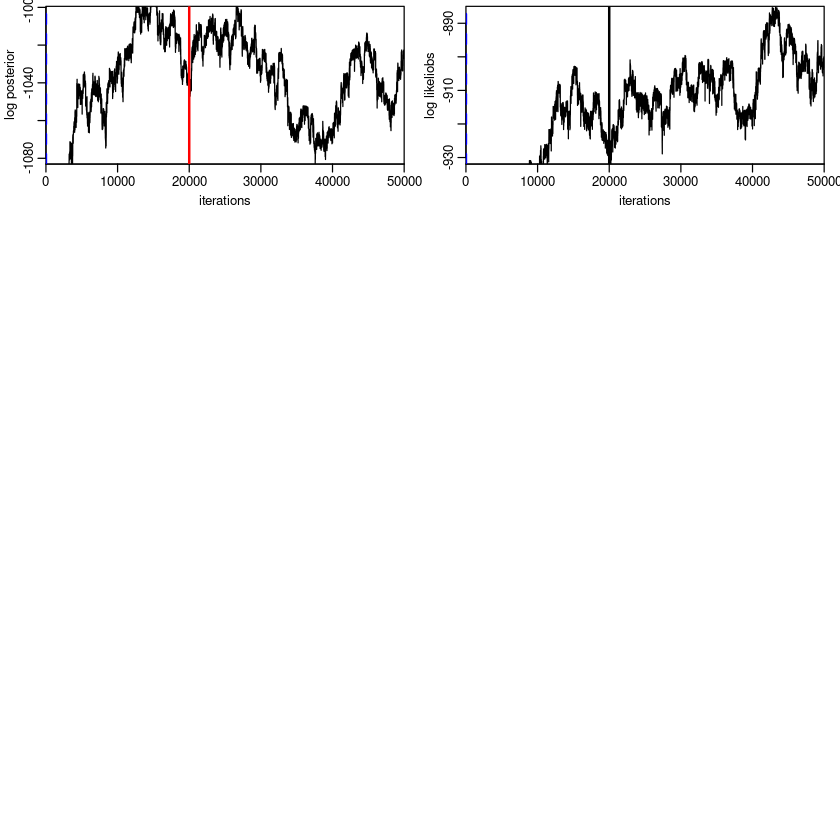

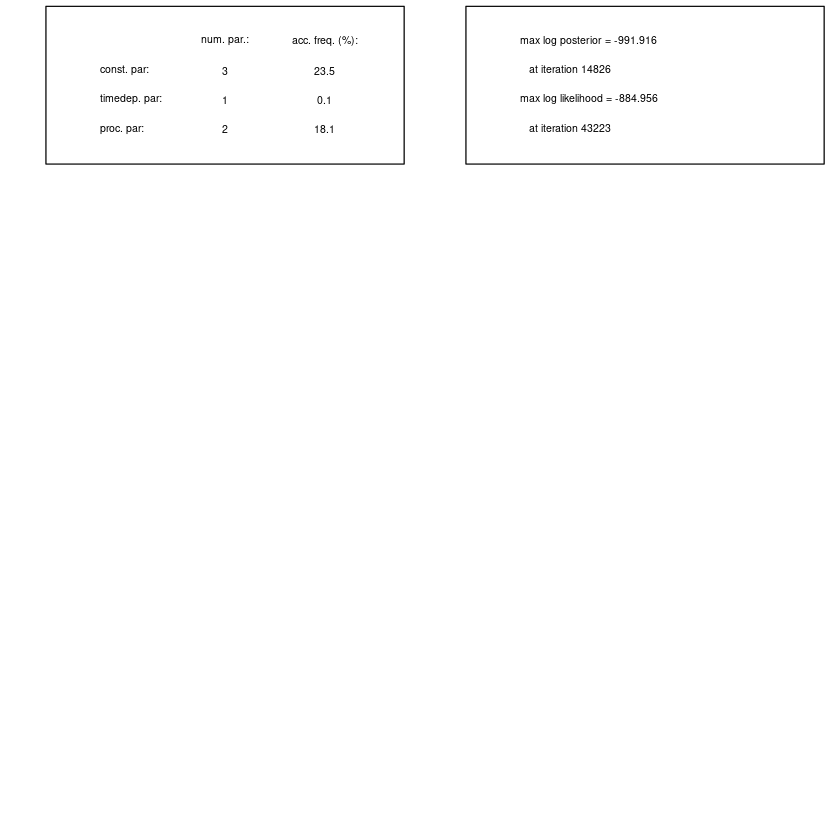

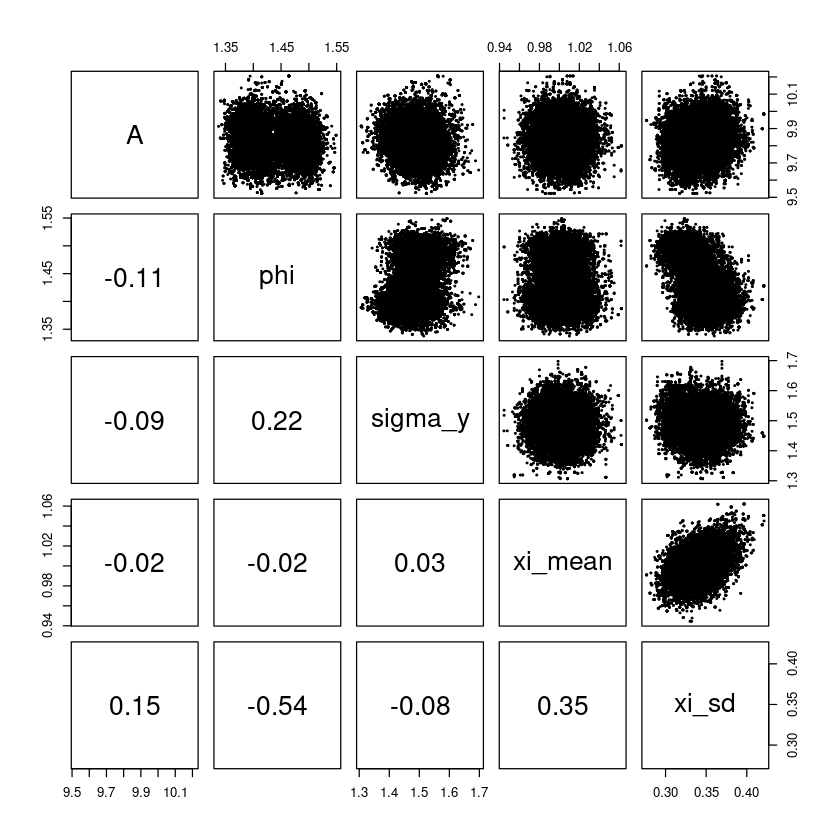

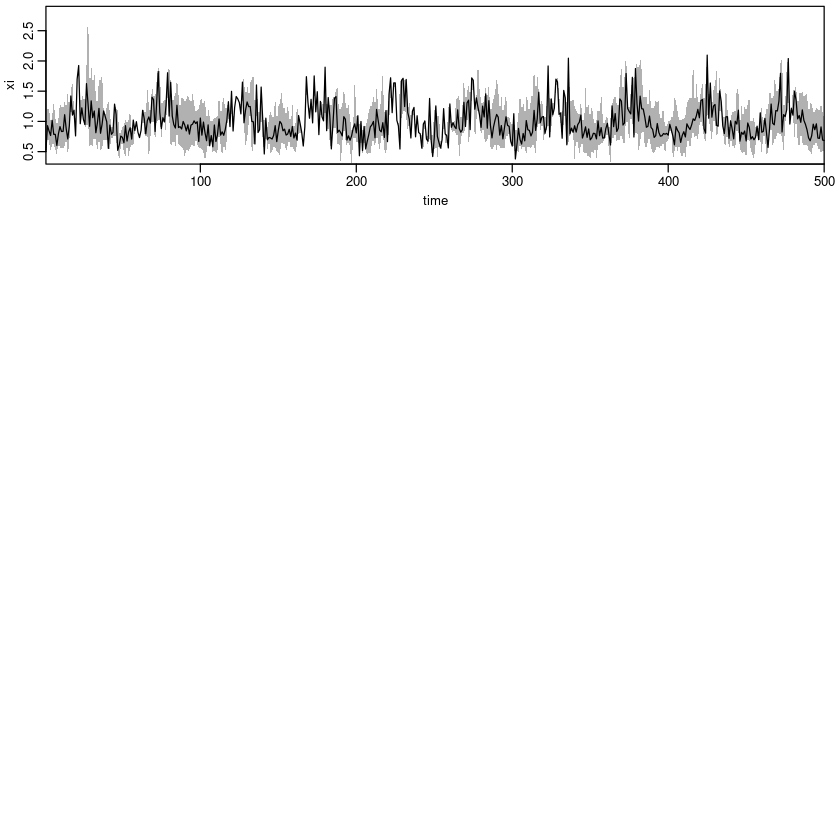

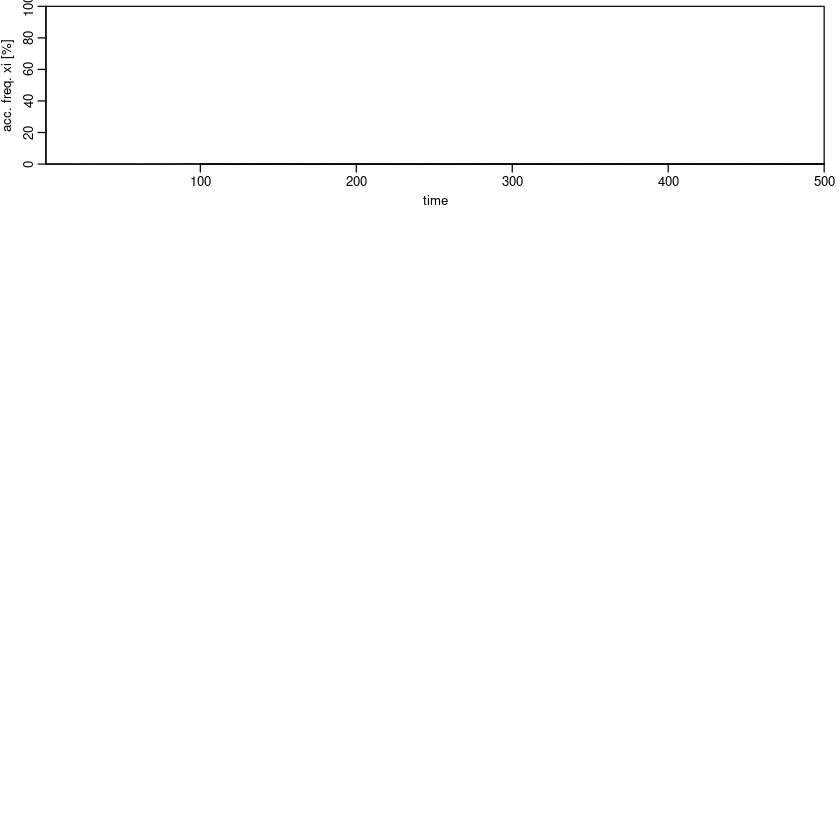

In [12]:
## 1. build proper two‑column matrix
xi_init <- cbind(
  time  = data[[t_name]],   # grid
  value = rep(1, nrow(data))# initial interval length
)

## 2. initial parameter list
param_init <- list(
  xi      = xi_init,
  A       = 10,
  phi     = 2,
  sigma_y = 1
)

## 3. call the sampler
res <- infer.timedeppar(
  loglikeli     = loglikeli,
  param.ini     = param_init,
  param.log     = c(A = FALSE, phi = FALSE,
                    sigma_y = TRUE,  # keep > 0
                    xi = TRUE),      # log‑normal OU for increments
  param.ou.ini  = c(xi_mean = 1, xi_sd = 0.3),
  param.ou.fixed= c(xi_gamma = 5),
  n.iter        = n.iter,
  control       = list(n.interval=n.interval, n.adapt=n.adapt),
  data          = data,
  verbose       = 1
)

plot(res);

### DF3

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          3

  number of time-dependent parameters:    1

  number of estimated process parameters: 2

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

50000 iterations completed

  acceptance frequency of constant parameters:             0.128

  acceptance frequencies of time-dependent parameters:     0.0204

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.19

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



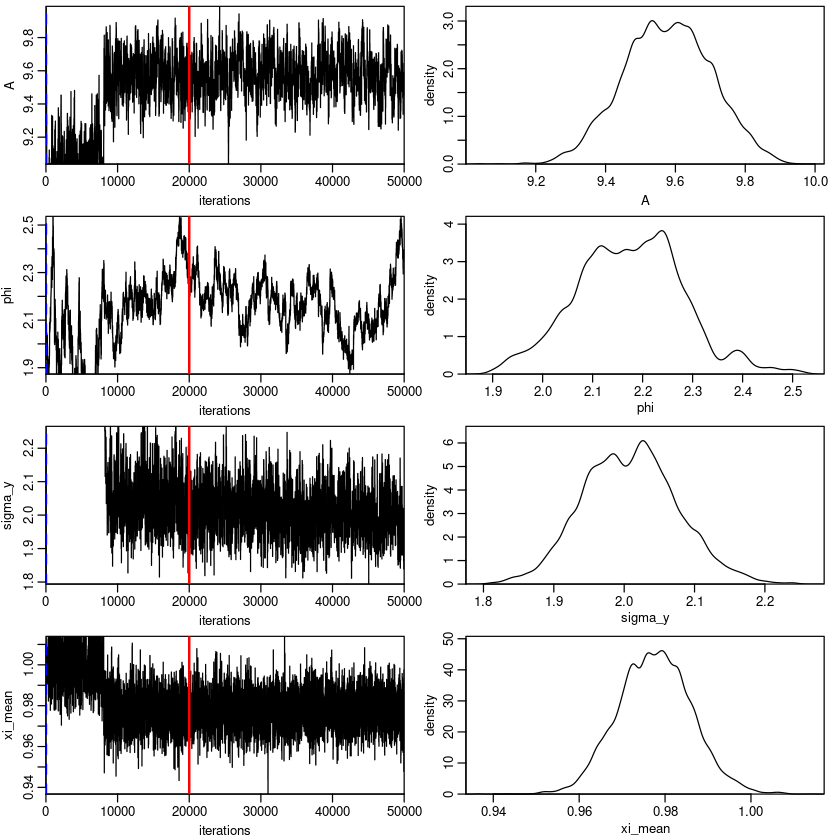

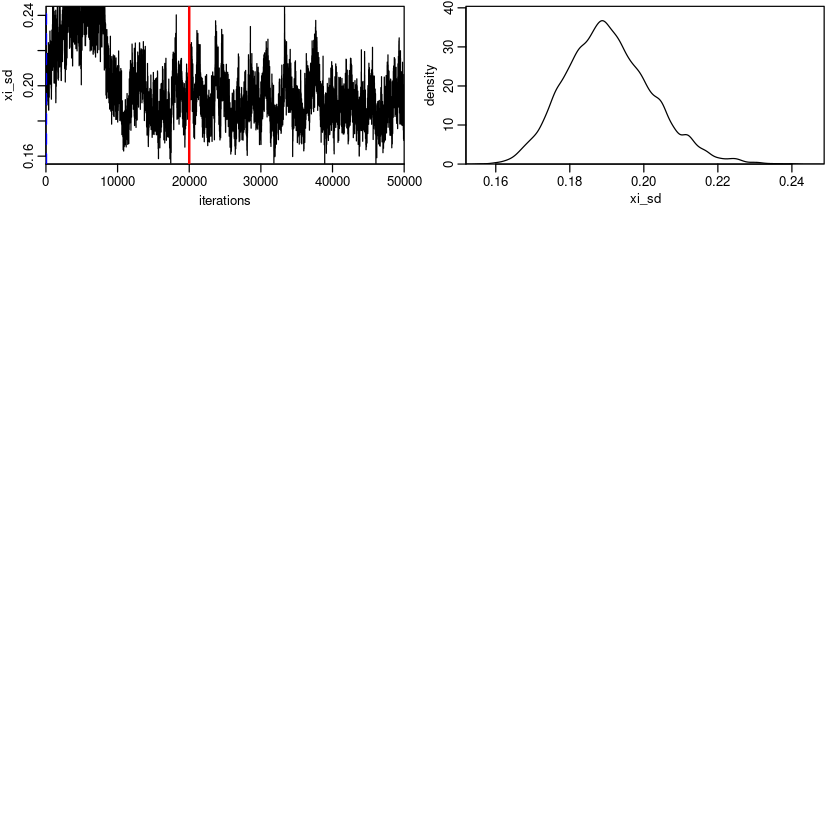

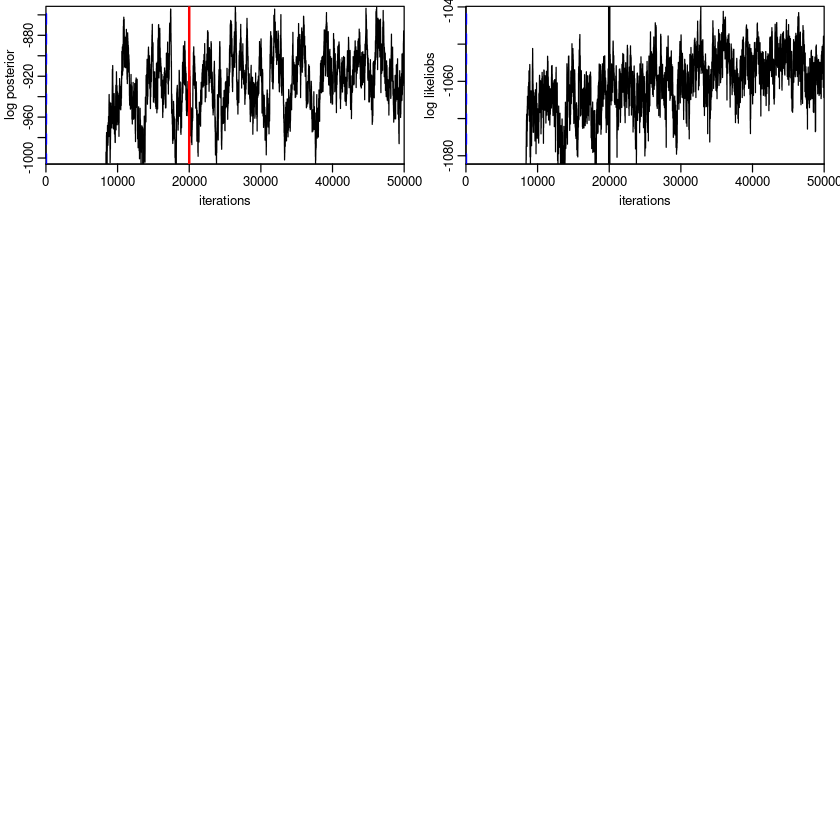

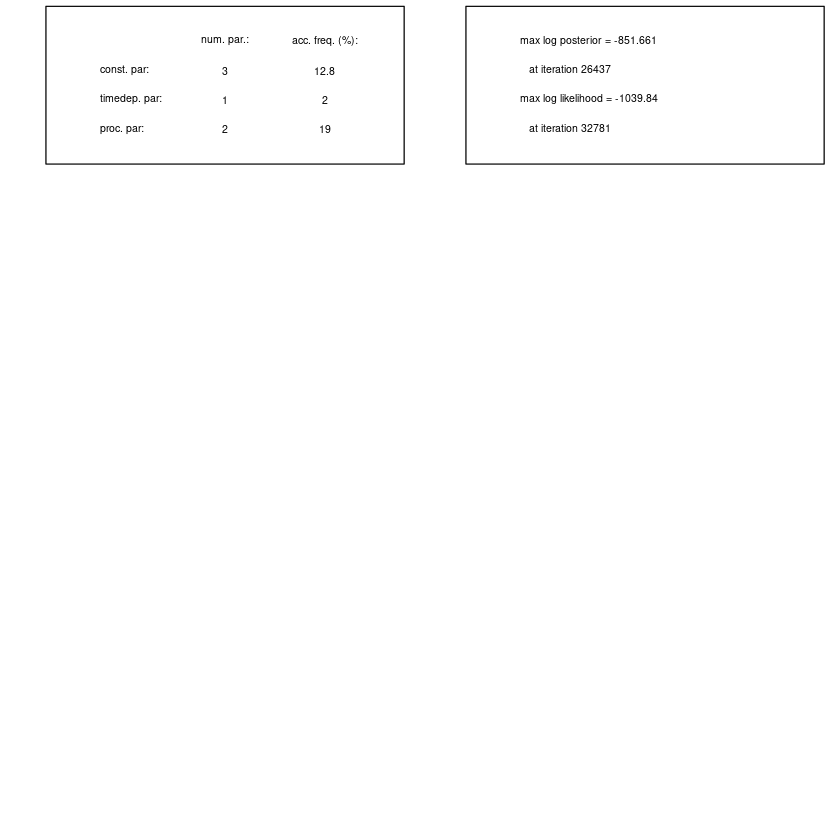

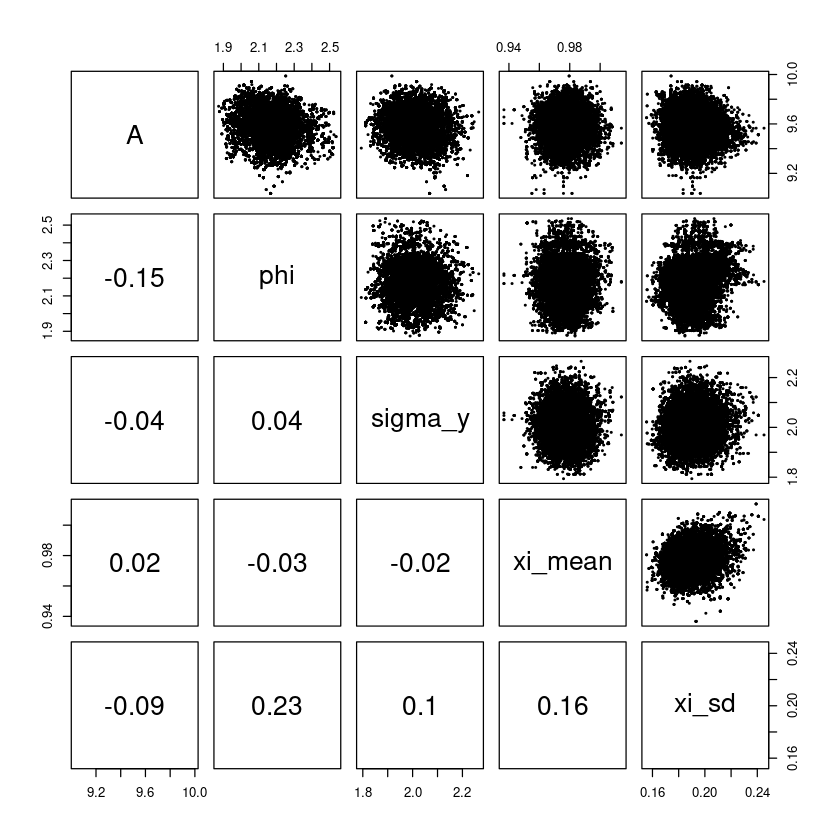

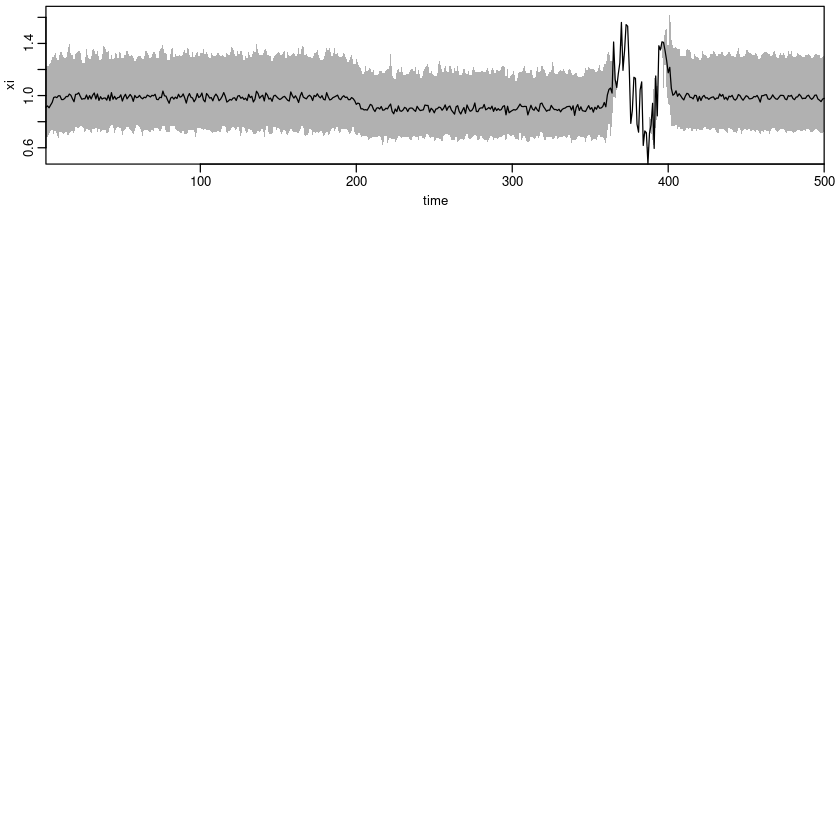

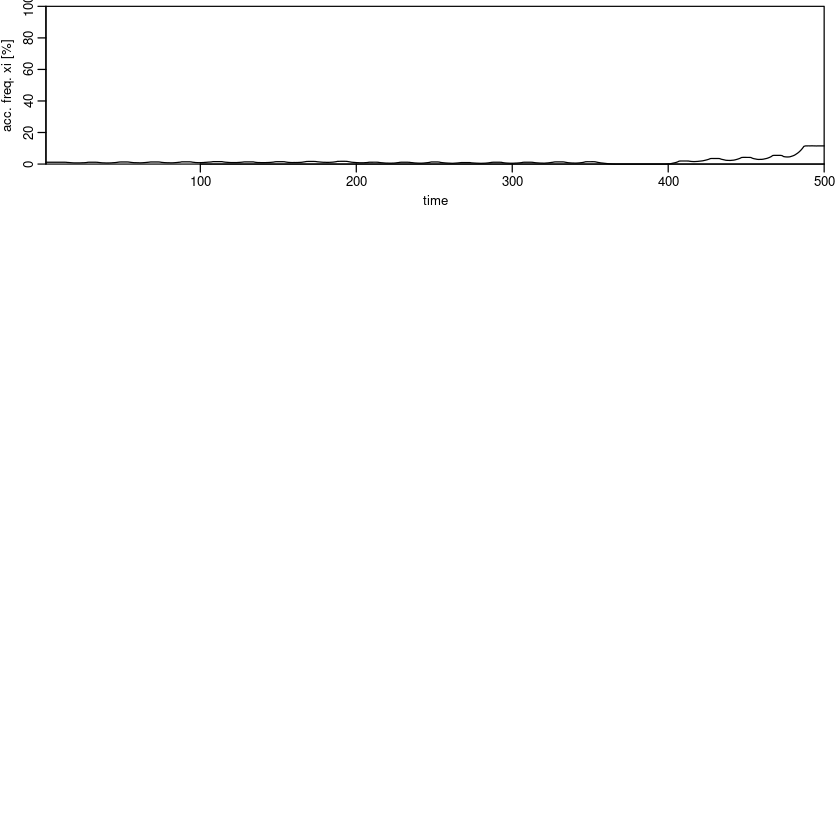

In [14]:
## 1. build proper two‑column matrix
xi_init <- cbind(
  time  = data[[t_name]],   # grid
  value = rep(1, nrow(data))# initial interval length
)

## 2. initial parameter list
param_init <- list(
  xi      = xi_init,
  A       = 10,
  phi     = 2,
  sigma_y = 1
)

## 3. call the sampler
res <- infer.timedeppar(
  loglikeli     = loglikeli,
  param.ini     = param_init,
  param.log     = c(A = FALSE, phi = FALSE,
                    sigma_y = TRUE,  # keep > 0
                    xi = TRUE),      # log‑normal OU for increments
  param.ou.ini  = c(xi_mean = 1, xi_sd = 0.3),
  param.ou.fixed= c(xi_gamma = 5),
  n.iter        = n.iter,
  control       = list(n.interval=n.interval, n.adapt=n.adapt),
  data          = data,
  verbose       = 1
)

plot(res);

In [395]:
res$sample.logpdf$posterior

ERROR: Error in res$sample.logpdf$posterior: $ operator is invalid for atomic vectors


In [403]:
res$sample.param.timedep$delta_t

1.0000000,2.0000000,3.00000000,4.0000000,5.0000000,6.00000000,7.0000000,8.0000000,9.0000000,10.0000000,⋯,491.0000000,492.0000000,493.0000000,494.0000000,495.0000000,496.000000,497.0000000,498.0000000,499.0000000,500.0000000
0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000
-1.3706449,-0.4047810,0.36952455,-0.7948866,-1.5597339,0.78775574,0.8623871,0.8668347,1.2404519,1.0776736,⋯,0.7532673,0.5093326,0.5954394,0.0634238,0.3243073,1.454180,1.1891145,0.8246166,0.5143556,0.1754233
1.1953677,0.4298016,1.00625025,-0.1476672,1.0539705,1.69810026,0.6488412,-0.2254223,1.8231608,0.4405597,⋯,0.6784188,1.0232574,0.4315866,-0.2105310,2.0796274,1.283684,-0.1371164,-0.6863696,-0.9138714,-0.1815294
0.8544215,1.9479888,0.04833694,0.2299874,0.8978654,0.07578447,1.0661712,1.7075509,1.5914905,1.3065440,⋯,0.9635489,1.1553081,0.9800990,0.4071198,0.5046269,1.531240,0.8549613,0.4981108,0.5052642,0.8802248
-0.5484248,0.1668196,0.61833170,-0.3453041,1.8074014,1.54655801,2.0530502,1.0423659,1.1157860,1.2953203,⋯,2.2907642,1.7306753,1.7752091,0.5351486,1.6228038,1.958293,1.1038986,1.3790180,1.9705293,1.6021274
1.6629383,1.4893440,1.13839906,2.1997543,1.4977415,1.64213429,1.1254484,1.4418513,0.3377311,1.1954927,⋯,0.9722750,0.1764762,0.8464412,1.5980643,2.3295982,1.458960,2.3971276,2.0090869,0.1822093,1.1347768
1.9372348,2.2632205,2.42458100,1.5195546,1.7113853,1.25934880,1.7233839,0.9946761,1.6790752,1.5111809,⋯,2.7643633,2.0573146,0.9312803,1.4604787,1.9807604,1.529822,0.8328023,2.0634688,1.7517250,2.6335648
1.0906175,0.9595868,1.83477016,1.4011500,1.0134516,0.65930648,1.2453859,0.9822638,0.9986139,1.7703096,⋯,1.4985538,1.8067170,1.9504437,1.8214538,1.1870002,1.605343,1.2332808,1.7090443,2.0318377,1.6806907
2.2338367,2.0019903,1.50141971,1.8597970,2.2926843,2.73271102,2.2520754,1.8409974,1.6493424,2.0192087,⋯,2.2379805,1.0083330,1.8682931,1.9477983,2.1162780,1.998217,1.4111568,2.6943799,2.2888395,1.9167243
2.3238341,2.0302377,1.57159881,1.1816295,1.6127208,2.22164026,3.3628434,2.2127223,2.1328241,1.7534256,⋯,1.5512006,2.2860530,3.0448326,2.7898901,2.4556206,3.311864,3.0951053,1.0034163,2.2497770,2.1897309


plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



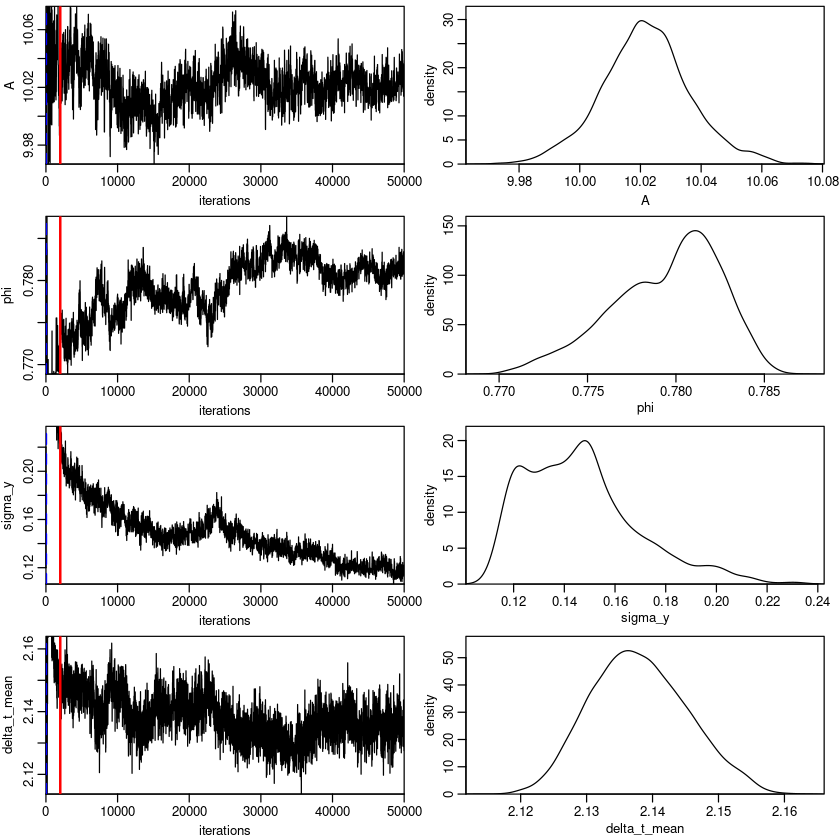

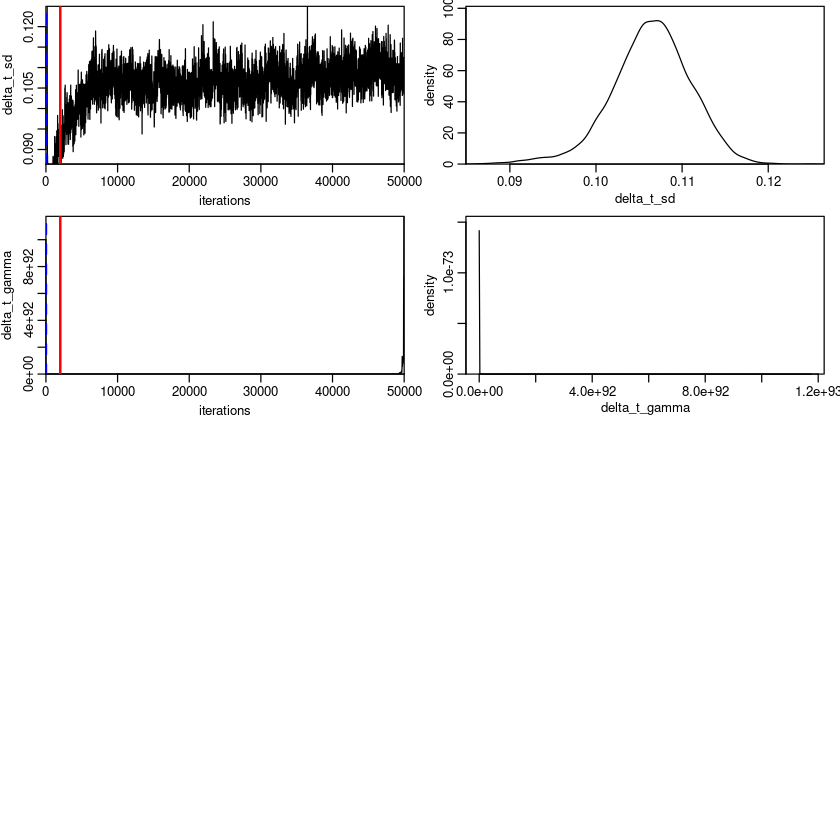

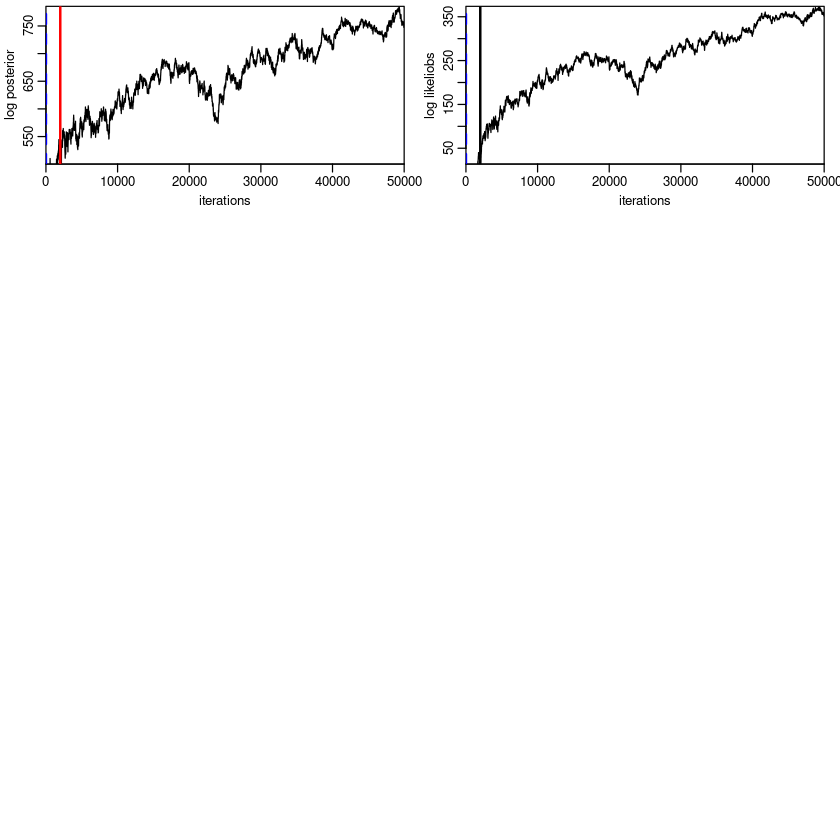

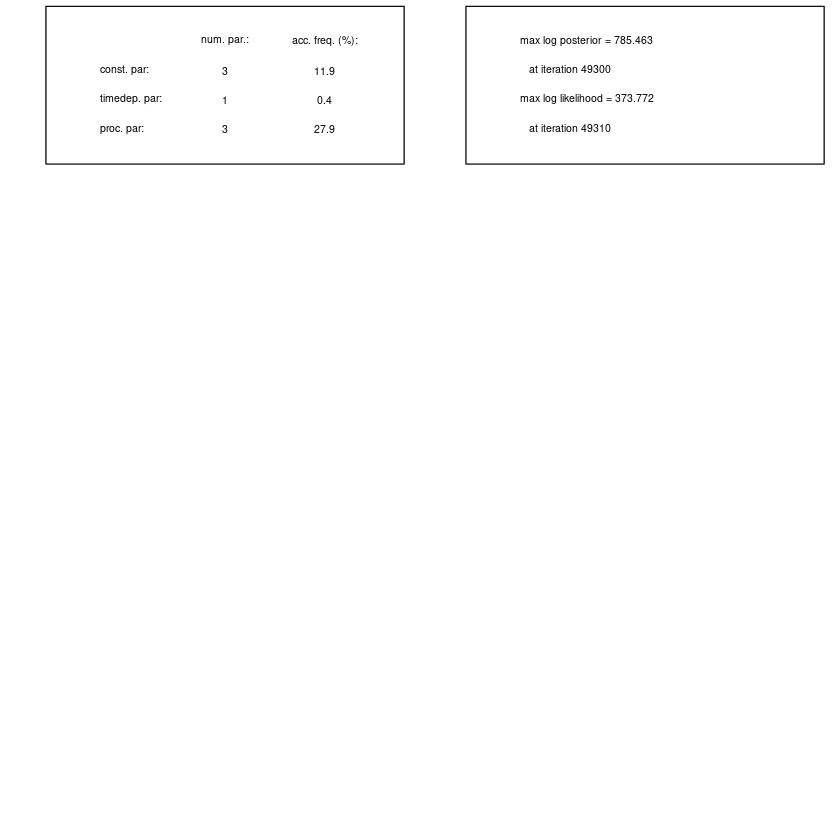

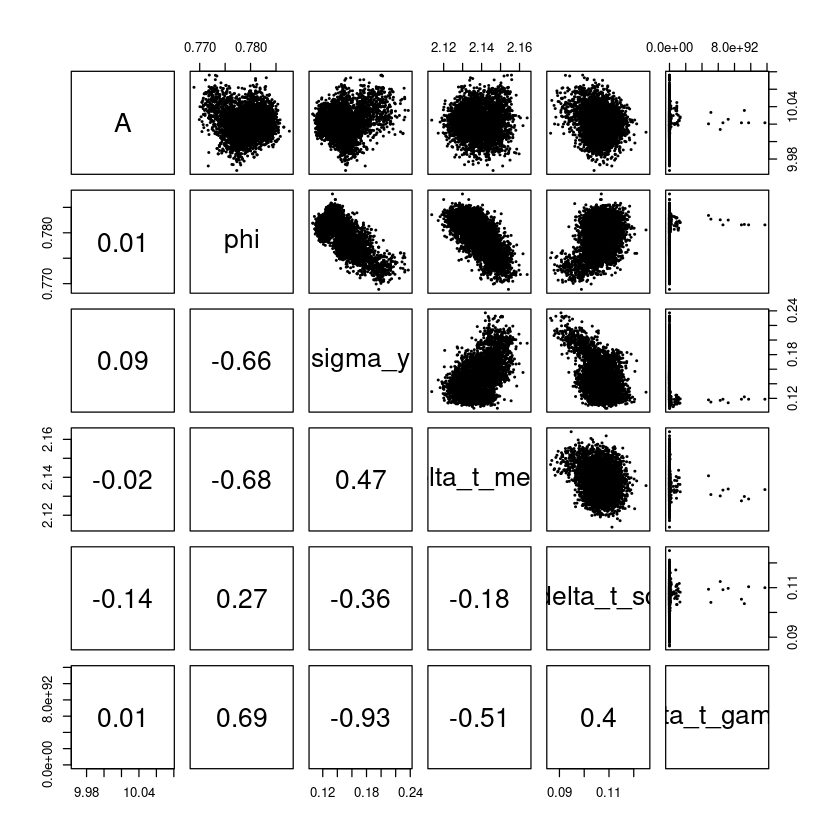

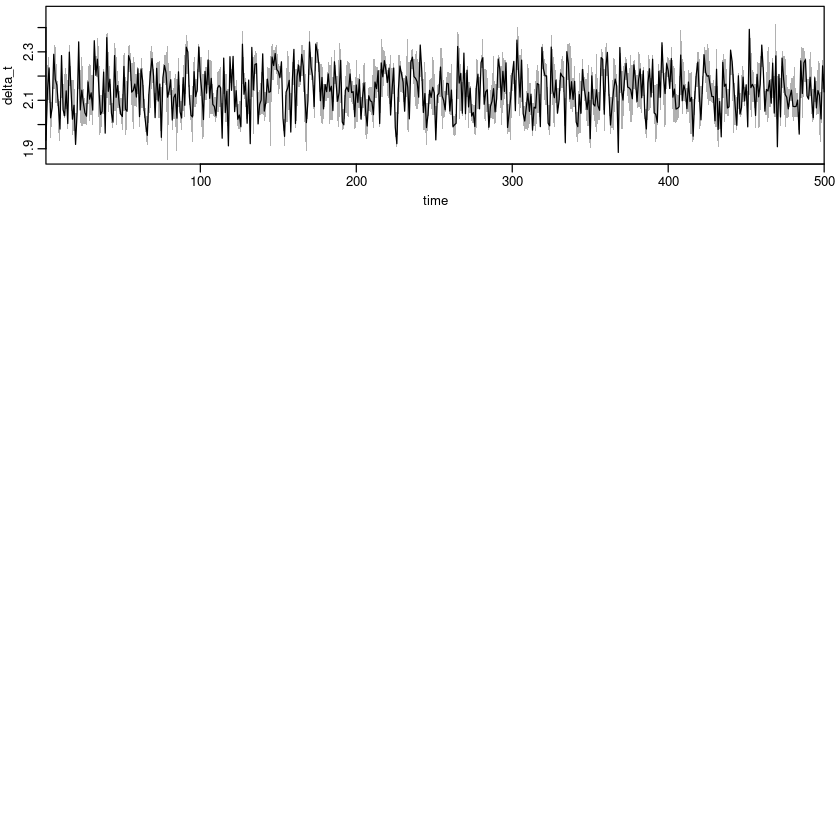

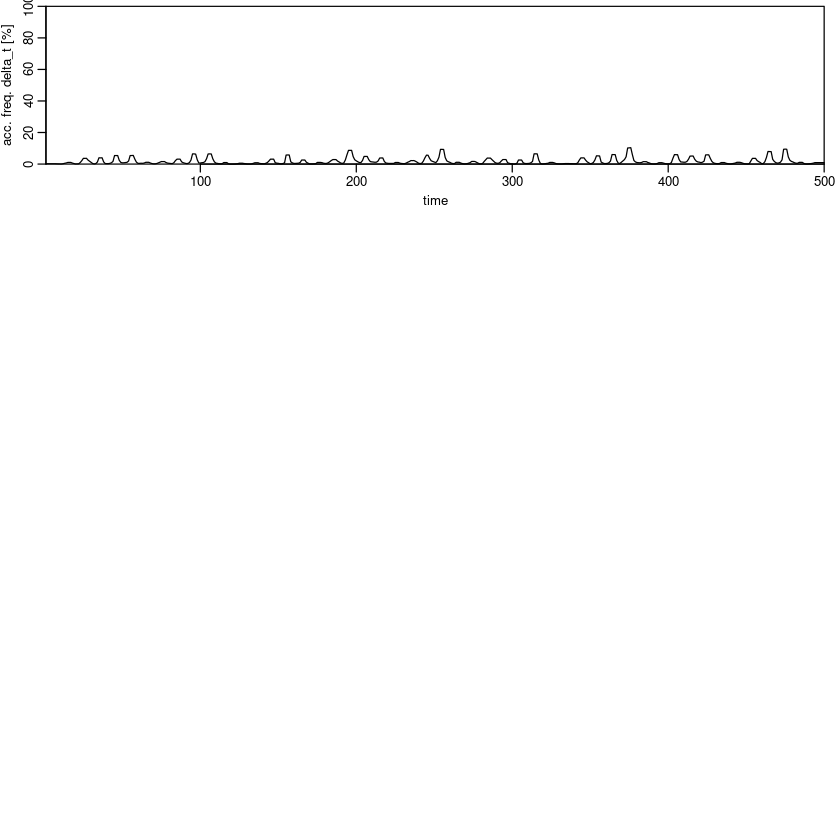

In [400]:

x <- cumsum(xis[nrow(xis),])
plot(x, 10*cos(2*pi * x / 11 + 2), col="blue", type="l", xlim=range(10))
lines(x, df1[[2]], col="red")

# Test 2

In [53]:
library(readxl)
library(timedeppar)

In [54]:
## likelihood
loglikeli <- function(param, data) {
    xi <- param$xi[,2]
    
    # build time series from intervals
    t <- cumsum(xi)
    
    # calculate frequency
    period <- 11 # years
    omega <- 2 * pi / period
    
    y_model <- param$A * cos(omega * t + param$phi)
    
    result <- sum(dnorm(data[[2]], mean=y_model,
                        sd=param$sigma_y, log=TRUE))
    return(result)
}

In [74]:
col_names <- c("Year_1", "Cycle_1", "blank1", "Year_2", 
               "Cycle_2", "blank2", "Year_3", "Cycle_3")
df <- read_excel("./data/syntheticData.xlsx", skip=4, 
                 col_names=col_names)
df1 <- df[,c(1,2)]
df2 <- df[,c(4,5)]
df3 <- df[,c(7,8)]

# specify the table to use
data = df1
t_name <- names(data)[1]
y_name <- names(data)[2]

# specify simulation parameters
n.iter <- 5000
n.interval <- 25
n.adapt <- floor(0.4 * n.iter)

In [75]:
# specify parameters of the model
xi_init <- matrix(c(data[[1]], rep(1, nrow(data))), ncol=2)
param_init <- list(
    xi = xi_init,
    A = 5,
    phi = 0,
    sigma_y = 1
)

In [76]:
res <- infer.timedeppar(
    loglikeli = loglikeli,
    param.ini = param_init,
    param.log = c(A=FALSE, phi=FALSE, sigma_y=TRUE, xi=TRUE),
    param.ou.ini = c(xi_mean=1, xi_sd=0.3),
    param.ou.fixed = c(xi_gamma=5),
    n.iter = n.iter,
    control = list(n.interval=n.interval, n.adapt=n.adapt),
    data = data
)

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          3

  number of time-dependent parameters:    1

  number of estimated process parameters: 2

5000 iterations completed

  acceptance frequency of constant parameters:             0.169

  acceptance frequencies of time-dependent parameters:     0.00888

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.175



plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



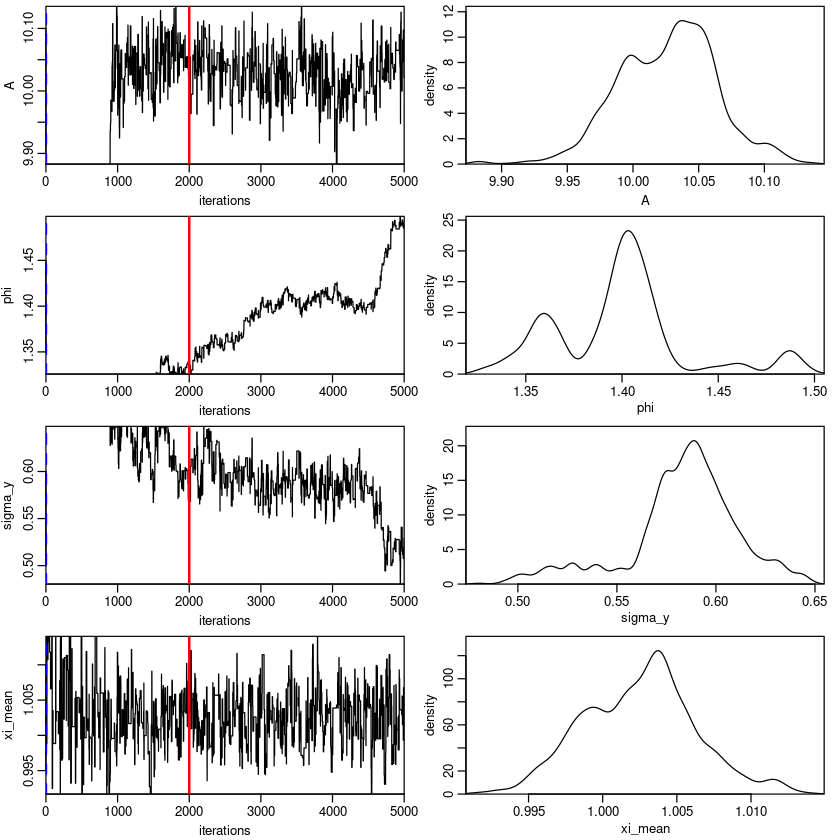

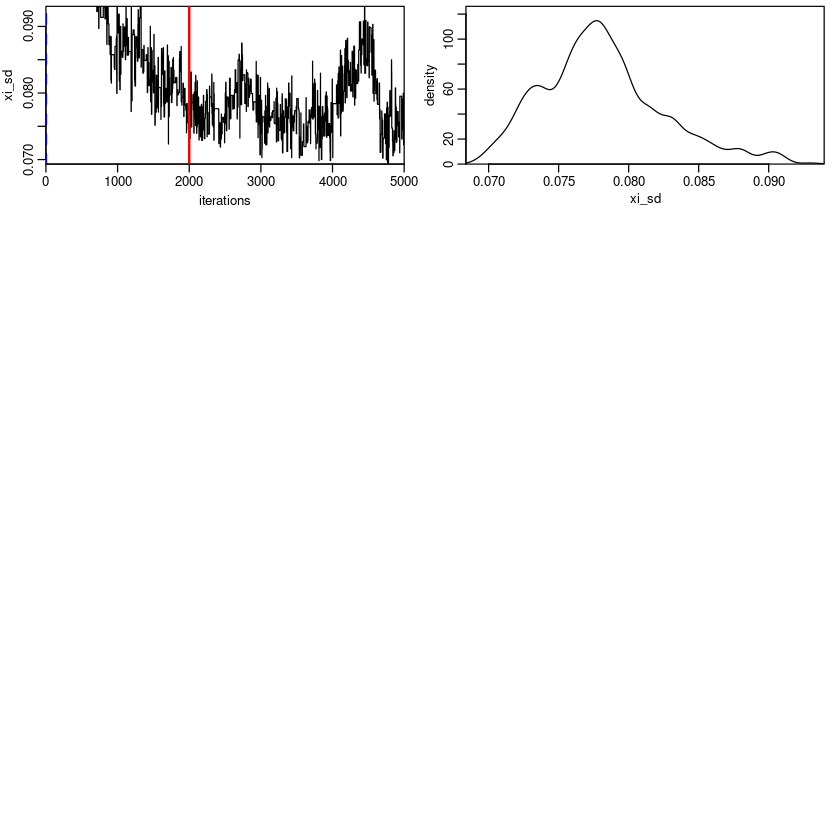

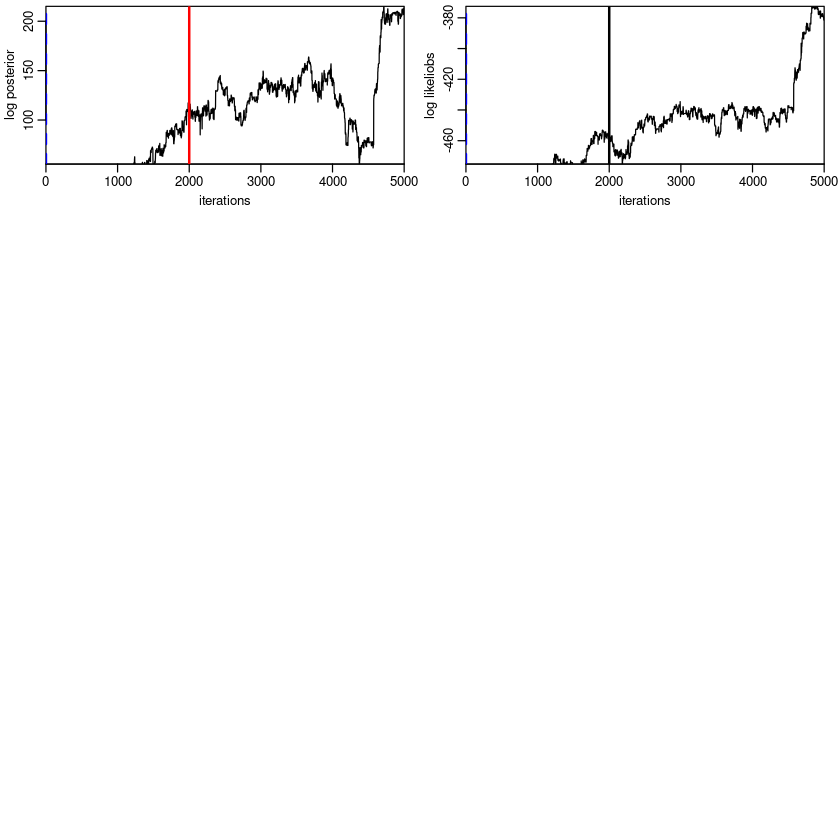

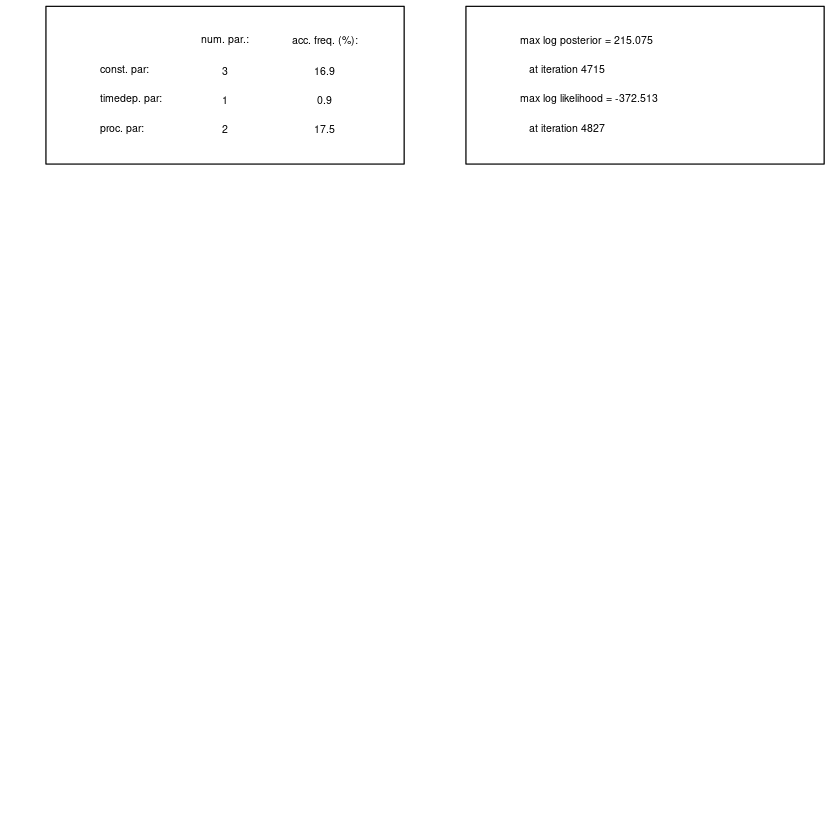

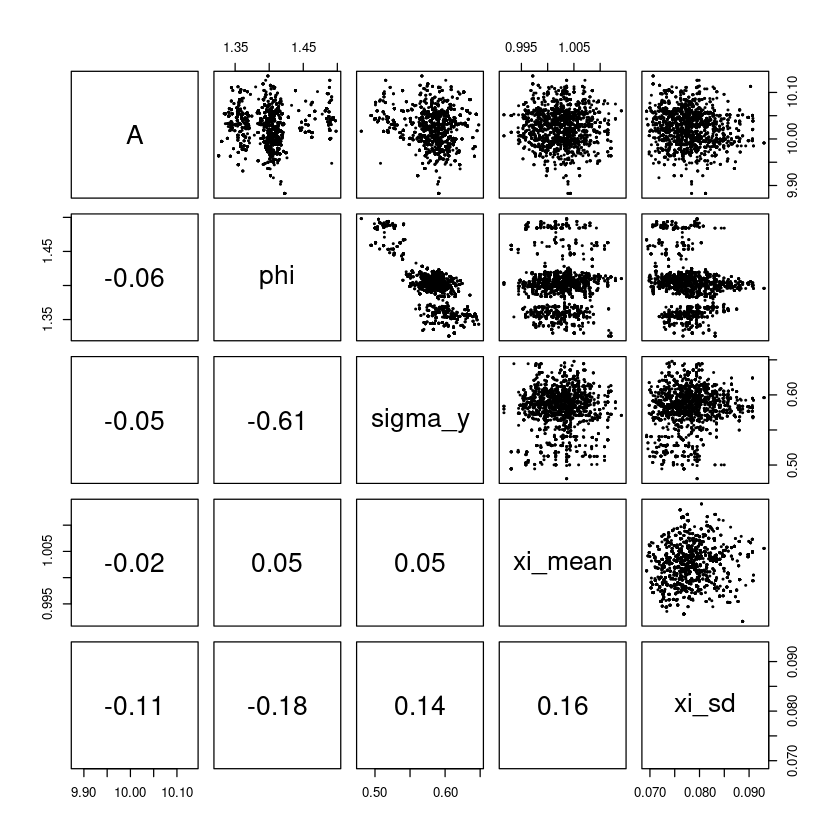

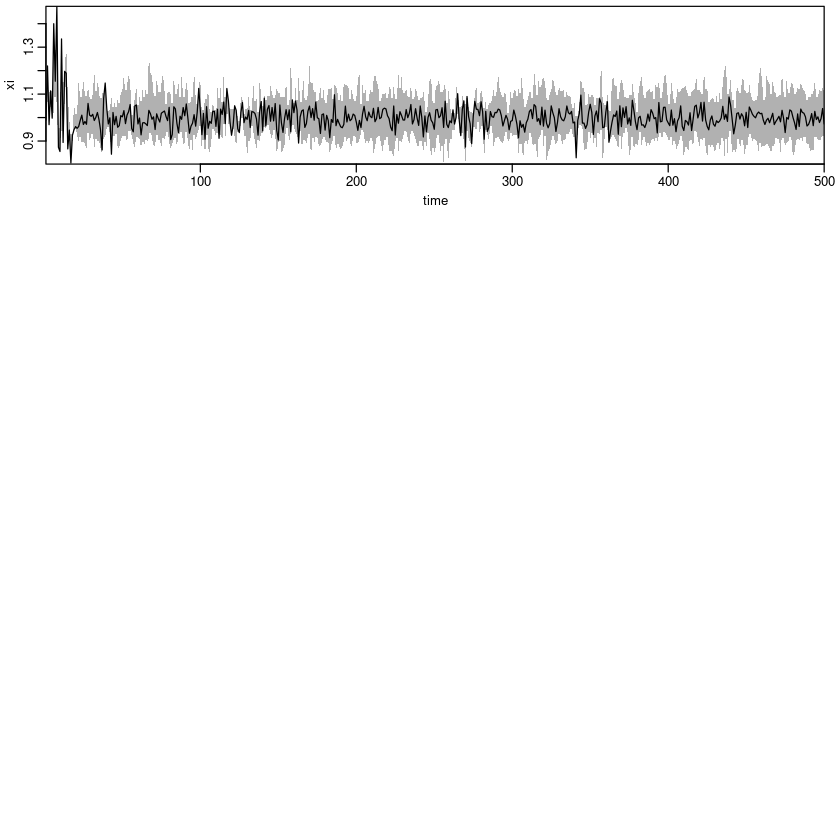

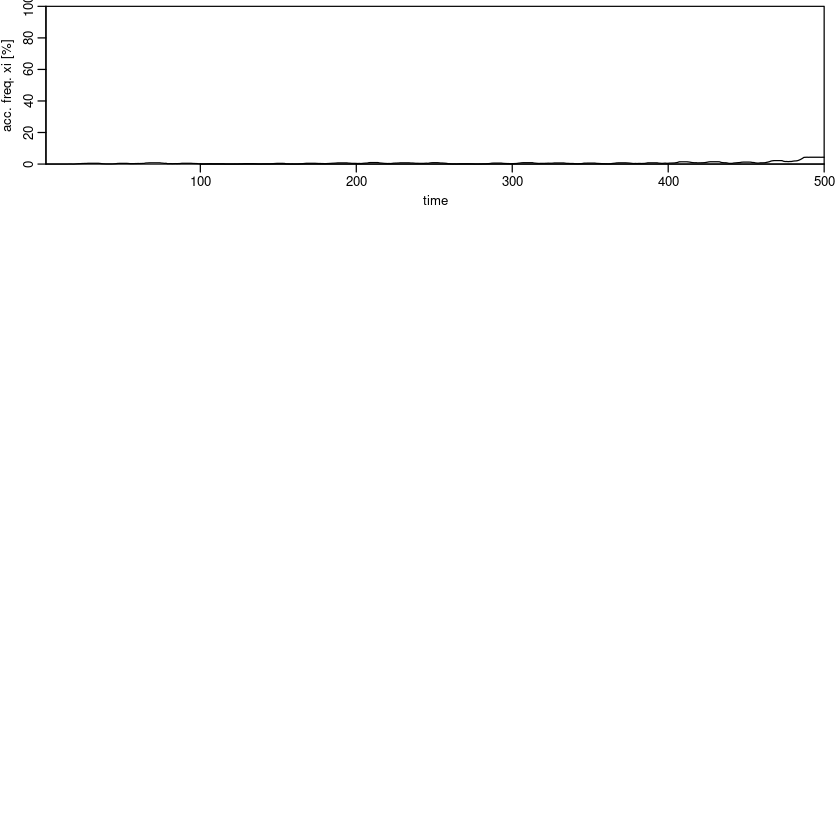

In [77]:
plot(res)